In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go 
from matplotlib.colors import TwoSlopeNorm

In [3]:
df_pwf16 = pd.read_csv('../data/DF_Intercambios.csv')
df_pwf25 = pd.read_csv('../data/DF_HVDC.csv').drop('Nome Elo', axis=1)
df_pwf16.columns = ['Nome Elo', 'Dia', 'Hora', 'P(MW)', 'Q(Mvar)']
df_pwf25.columns = ['Nome Elo', 'Dia', 'Hora', 'P(MW)', 'Q(Mvar)']

df_pwf = pd.concat([df_pwf16, df_pwf25], axis=0).reset_index().drop('index', axis=1)

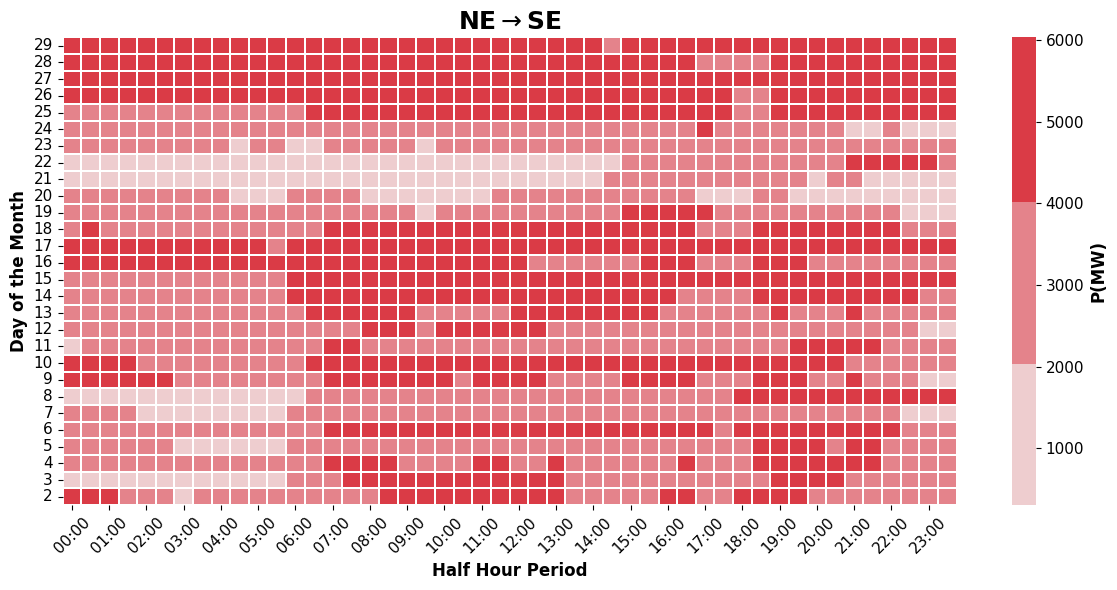

In [52]:
class CreatePlots:
    def __init__(self):
        pass

    def persistency_curve(self, dataset, nome_elo=None, col=None, 
                          frm=None, to=None, path=None, ax_fontsize=None):
        
        dataset = pd.DataFrame(dataset[dataset['Nome Elo'] == nome_elo][col])

        fig, ax = plt.subplots(figsize=(12, 6))

        x = np.sort(np.array(dataset[col]))
        N = len(x)
        y = np.linspace(1, N, N)

        import_values = len(dataset[dataset[col] < 0])
        export_values = len(dataset[dataset[col] > 0])
        
        total_import = round((import_values / N) * 100, 2)
        total_export = round((export_values / N) * 100, 2)


        plt.plot(y[:import_values], x[:import_values], lw=3, c='red', label=f'Import: {total_import}% (-)')
        plt.plot(y[import_values:export_values], x[import_values:export_values], lw=3, c='blue', label=f'Export: {total_export}% (+)')
        ax.set_ylabel(f'{col}', weight='bold', fontsize=14) 
        ax.set_title(fr'Persistency Curve {frm}$\rightarrow${to}', weight='bold', fontsize=20)
        ax.set_xlabel('# Operation Points', weight='bold', fontsize=14)
 
        ax.axhline(y=0, color='k', ls='--', alpha=0.3)
        ax.tick_params(color='black', labelcolor='black')
        ax.grid(visible=True, alpha=0.3)

        ax.tick_params(axis='both', which='major', labelsize=ax_fontsize)
        ax.tick_params(axis='both', which='minor', labelsize=ax_fontsize)

        ax.legend(bbox_to_anchor=(0.01, 1.00), fontsize=13, 
          loc='upper left', fancybox=True, shadow=True)
        
        plt.tight_layout()

        if path != None:
            plt.savefig(f'{path}/PC_{nome_elo}')

        plt.show()

    def box_plots(self, dataset, col=None, path=None, ax_fontsize=None):
        import warnings
        warnings.filterwarnings('ignore')

        fig, ax = plt.subplots(1, 1, figsize=(15, 6))
        ax = sns.boxplot(
            data=dataset, 
            x="Nome Elo", 
            y=col, 
            notch=True, 
            showcaps=False,
            flierprops={"marker": "x"}, 
            hue=df_pwf['Nome Elo'],
            palette=sns.color_palette("hls", 8)
        )

        ax.set_ylabel(f'{col}', weight='bold', fontsize=13)
        ax.set_xlabel('Nome Elo', weight='bold', fontsize=13)
        ax.grid(True, alpha=0.3)
        ax.set_xticklabels(dataset['Nome Elo'].unique(), rotation=30)

        ax.tick_params(axis='both', which='major', labelsize=ax_fontsize)
        ax.tick_params(axis='both', which='minor', labelsize=ax_fontsize)

        plt.tight_layout()

        if path != None:
            plt.savefig(f'{path}/BoxPlot_{col}')

        plt.show()

    def violin_plots(self, dataset, col=None, path=None, ax_fontsize=None):
        import warnings
        warnings.filterwarnings('ignore')

        fig, ax = plt.subplots(1, 1, figsize=(15, 6))
        ax = sns.violinplot(
            data=dataset, 
            x="Nome Elo", 
            y=col, 
            hue=df_pwf['Nome Elo'],
            palette=sns.color_palette("hls", 8)
        )

        ax.set_ylabel(f'{col}', weight='bold', fontsize=13)
        ax.set_xlabel('Nome Elo', weight='bold', fontsize=13)
        ax.grid(True, alpha=0.3)
        ax.set_xticklabels(dataset['Nome Elo'].unique(), rotation=30)

        ax.tick_params(axis='both', which='major', labelsize=ax_fontsize)
        ax.tick_params(axis='both', which='minor', labelsize=ax_fontsize)

        plt.tight_layout()

        if path != None:
            plt.savefig(f'{path}/ViolinPlot_{col}')

        plt.show()
    
    def create_heatmap(self, dataset, col, k, path=None, ax_fontsize=None):
        df_pwf_elos   = dataset['Nome Elo'].unique()

        if k == 0:
            frm = df_pwf_elos[k][-2:]
            to = 'T'
        elif k == 5:
            frm = df_pwf_elos[k].split('_')[1]
            to  = 'T'
        else:
            splt1 = df_pwf_elos[k].split('_')
            splt2 = splt1[1].split('-')
            frm = splt2[0]
            to = splt2[1]

        max_day = max(sorted(list(set(dataset['Dia']))))
        min_day = min(sorted(list(set(dataset['Dia']))))
        n_days = len(sorted(list(set(dataset['Dia']))))
        half_hour_list = sorted(list(set(dataset['Hora'])))
        n_half_hour = len(half_hour_list)
        half_hour_periods = pd.date_range(start='2023-10-17', 
                                          periods=n_half_hour, freq='30T').strftime('%H:%M')

        elo_dataset = dataset[dataset['Nome Elo'] == df_pwf_elos[k]]

        active_power = np.array(elo_dataset[col]).reshape(n_days, -1)
        heatmap_data = pd.DataFrame(active_power[::-1], 
                                    index=range(max_day, min_day-1, -1), 
                                    columns=half_hour_periods) 

        vmax = elo_dataset[col].max()
        vmin = elo_dataset[col].min()

        neg_values = len(elo_dataset[elo_dataset[col] < 0])

        if vmin >= 0 or (vmin <= 0 and vmax <= 0) or neg_values < 30:
            cmap = sns.diverging_palette(230, 10, as_cmap=False)
        else:
            cmap = 'seismic'

        fig, ax = plt.subplots(1, 1, figsize=(12, 6))

        ax = sns.heatmap(heatmap_data, cmap=cmap, center=0, 
                    xticklabels=2, cbar_kws={'label': col}, 
                    linewidths=0.1, linecolor="white", mask=heatmap_data == 0.0)  
        cbar = ax.collections[0].colorbar
        cbar.ax.tick_params(labelsize=11)
        cbar.ax.set_ylabel(col, size=12, weight='bold')

        plt.xticks(rotation=45)

        ax.set_xlabel('Half Hour Period', weight='bold', fontsize=12)
        ax.set_ylabel('Day of the Month', weight='bold', fontsize=12)
        ax.set_title(fr'{frm}$\rightarrow${to}', weight='bold', fontsize=18)

        if ax_fontsize != None:
            ax.tick_params(axis='both', which='major', labelsize=ax_fontsize)
            ax.tick_params(axis='both', which='minor', labelsize=ax_fontsize)

        plt.tight_layout()
        if path != None:
            plt.savefig(f'{path}/Heatmap_{frm}_{to}')
        plt.show()


    def create_contourplot(self, dataset, k, col, frm=None, to=None, path=None, ax_fontsize=12):
        df_pwf_elos   = dataset['Nome Elo'].unique()
        Dia           = np.array(dataset[dataset['Nome Elo'] == df_pwf_elos[0]]['Dia'])
        Hora          = np.array(dataset[dataset['Nome Elo'] == df_pwf_elos[0]]['Hora'])
        Fluxo_NE      = np.array(dataset[dataset['Nome Elo'] == df_pwf_elos[0]][col])
        Fluxo_NESE    = np.array(dataset[dataset['Nome Elo'] == df_pwf_elos[1]][col])
        Fluxo_NS      = np.array(dataset[dataset['Nome Elo'] == df_pwf_elos[2]][col])
        Fluxo_SULSECO = np.array(dataset[dataset['Nome Elo'] == df_pwf_elos[3]][col])
        Fluxo_NEN     = np.array(dataset[dataset['Nome Elo'] == df_pwf_elos[4]][col])
        Fluxo_RSUL    = np.array(dataset[dataset['Nome Elo'] == df_pwf_elos[5]][col])
        Elo_FOZIBIUNA = np.array(dataset[dataset['Nome Elo'] == df_pwf_elos[6]][col])
        Elo_PVELARARQ = np.array(dataset[dataset['Nome Elo'] == df_pwf_elos[7]][col])
        Elo_CPVBPVEL  = np.array(dataset[dataset['Nome Elo'] == df_pwf_elos[8]][col])
        Elo_XINGUSE   = np.array(dataset[dataset['Nome Elo'] == df_pwf_elos[9]][col])

        df_dict = {'Dia': Dia, 'Hora': Hora, df_pwf_elos[0]: Fluxo_NE, df_pwf_elos[1]: Fluxo_NESE, 
                   df_pwf_elos[2]: Fluxo_NS, df_pwf_elos[3]: Fluxo_SULSECO, df_pwf_elos[4]: Fluxo_NEN,
                   df_pwf_elos[5]: Fluxo_RSUL, df_pwf_elos[6]: Elo_FOZIBIUNA, df_pwf_elos[7]: Elo_PVELARARQ,
                   df_pwf_elos[8]: Elo_CPVBPVEL, df_pwf_elos[9]: Elo_XINGUSE}
        df_pwf_total = pd.DataFrame(df_dict)
        df_pwf_hour = df_pwf_total[::2].reset_index().drop('index', axis=1)

        dia = np.unique(df_pwf_hour['Dia'])
        hora = np.unique(df_pwf_hour['Hora'])

        z_flows = []
        vals = []
        flow_cols = list(df_pwf_hour.columns[2:])

        for j in range(0, len(flow_cols)):
            lst = []
            for i in range(0, 673):
                if i % 24 == 0 and i != 0:
                    lst.append(vals)
                    vals = []
                
                if i == 672:
                    break
                vals.append(df_pwf_hour[flow_cols[j]][i])
            z_flows.append(lst)


        fig, ax = plt.subplots(1, 1, figsize=(12, 6))

        norm   = TwoSlopeNorm(0)
        contour = ax.contourf(hora, dia[::-1], np.array(z_flows[k][::-1]), 20, 
                            cmap='RdBu_r', 
                            extend='max', 
                            norm=norm)
        # else:
        #     contour = ax.contourf(hora, dia[::-1], np.array(z_flows[k][::-1]), 20, 
        #                         cmap='RdBu_r', 
        #                         extend='max',  
        #                         norm=norm)

        cbar1 = plt.colorbar(contour, ax=ax)
        cbar1.formatter.set_powerlimits((3, 3))
        cbar1.formatter.set_useMathText(True)
        cbar1.ax.set_ylabel(f'{col}', rotation=90, weight='bold', size=12)

        ax.set_xlabel("Hour", weight='bold', fontsize=ax_fontsize)
        ax.set_ylabel("Day", weight='bold', fontsize=ax_fontsize)
        ax.set_yticks(np.arange(2, 30))
        ax.set_xticks(np.arange(0, 24))
        ax.set_xticklabels(hora, rotation=45)
        ax.set_title(fr'Fluxo {frm}$\rightarrow${to}', weight='bold', fontsize=18)

        plt.tight_layout()
        if path != None:
            plt.savefig(f'{path}/ContourPlot_{frm}_{to}')

        plt.show()  

# ['EXP_NE', 'Fluxo_NE-SE', 'Fluxo_N-S', 'Fluxo_SUL-SECO', 'Fluxo_NE-N', 'Fluxo_RSUL', 'Elo_FOZ-IBIUNA', 'Elo_PVEL-ARARQ', 'Elo_CPVBTB-PVEL', 'Elo_XINGU-SE']
path = '../results'
plotter = CreatePlots()
plotter.create_heatmap(dataset=df_pwf, 
                           col='P(MW)',
                           k=1, 
                           path=path, 
                           ax_fontsize=11)

In [88]:
k = 2
df_pwf_elos = 'Fluxo_N-S'
frm = None
to = None

# ['EXP_NE', 'Fluxo_NE-SE', 'Fluxo_N-S', 'Fluxo_SUL-SECO', 'Fluxo_NE-N', 'Fluxo_RSUL', 'Elo_FOZ-IBIUNA', 'Elo_PVEL-ARARQ', 'Elo_CPVBTB-PVEL', 'Elo_XINGU-SE']
if k == 0:
    frm = df_pwf_elos[-2:]
    to = 'T'
else:
    splt1 = df_pwf_elos.split('_')
    splt2 = splt1[1].split('-')

    frm = splt2[0]
    to = splt2[1]

print(frm, to)

N S
